In [1]:
import numpy as np
import os, sys
current_dir = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.insert(0, current_dir)
sys.path.insert(0, os.path.join(current_dir, 'conv_gp/'))
from conv_gp.models import ModelBuilder
from argparse import Namespace
import observations

import gpflow

In [2]:
model_path = './model.npy'
flags = Namespace(
    M='384,384,384',
    strides='3,1,1',
    feature_maps='10,10',
    filter_sizes='5,3,3',
    batch_size=64,
    base_kernel='rbf',
    last_kernel='conv',
    load_model=model_path,
    identity_mean=False,
    white=False,
    num_samples=5
)

In [3]:
(Xtrain, Ytrain), (Xtest, Ytest) = observations.cifar10('/tmp/cifar10')
Xtrain = np.transpose(Xtrain, [0, 2, 3, 1]).astype(np.float64)
Xtest = np.transpose(Xtest, [0, 2, 3, 1]).astype(np.float64)
Xtrain /= 255.0
Xtest /= 255.0

std = Xtrain.std(axis=(0, 1, 2))
mean = Xtrain.mean(axis=(0, 1, 2))
Xtrain -= mean
Xtrain /= std
Xtest -= mean
Xtest /= std

builder = ModelBuilder(flags, Xtrain, Ytrain, model_path=flags.load_model)
model = builder.build()

In [4]:
def test_accuracy_at_noise_level(noise_level):
    temp_test = (Xtest * std) + mean
    corrupted_test = temp_test + np.random.randn(*Xtest.shape) * noise_level
    corrupted_test = np.where(np.less_equal(corrupted_test, 1.0), corrupted_test, np.ones_like(corrupted_test))
    corrupted_test = np.where(np.greater_equal(corrupted_test, 0.0), corrupted_test, np.zeros_like(corrupted_test))
  
    corrupted_test -= mean
    corrupted_test /= std
    
    correct = 0
    batch_size = 64
    for i in range(len(Ytest) // batch_size + 1):
        batch_slice = slice(i * batch_size, (i+1) * batch_size)
        X = corrupted_test[batch_slice] 
        X += np.random.randn(*X.shape) * noise_level
        Y = Ytest[batch_slice]
        X = X.reshape(X.shape[0], -1) 
        mean_predict, _ = model.predict_y(X, 10)
        class_probs = mean_predict.mean(axis=0)
        predicted = class_probs.argmax(axis=1)
        correct += (predicted == Y).sum()

    accuracy = correct / len(Ytest)
    print("accuracy: {}, noise_level: {}".format(accuracy, noise_level))

In [8]:
test_accuracy_at_noise_level(0.0)
test_accuracy_at_noise_level(0.1)
test_accuracy_at_noise_level(0.25)
test_accuracy_at_noise_level(0.5)
test_accuracy_at_noise_level(1.0)

accuracy: 0.7382, noise_level: 0.0
accuracy: 0.6532, noise_level: 0.1
accuracy: 0.3371, noise_level: 0.25
accuracy: 0.154, noise_level: 0.5
accuracy: 0.1101, noise_level: 1.0


In [5]:
saved_params = np.load(model_path).item()
sess = model.enquire_session()
model_params = {}
for param in model.parameters:
    saved = saved_params[param.pathname]
    value = sess.run(param.constrained_tensor)
    model_params[param.pathname] = value
    print(param.pathname, "diff ", np.linalg.norm(saved - value))

DGP/likelihood/likelihood/invlink/epsilon diff  0.0
DGP/layers/0/conv_kernel/base_kernel/variance diff  0.0
DGP/layers/0/conv_kernel/base_kernel/lengthscales diff  0.0
DGP/layers/0/conv_kernel/base_kernel/variance diff  0.0
DGP/layers/0/conv_kernel/base_kernel/lengthscales diff  0.0
DGP/layers/0/feature/Z diff  0.0
DGP/layers/0/q_mu diff  0.0
DGP/layers/0/q_sqrt diff  0.0
DGP/layers/1/conv_kernel/base_kernel/variance diff  0.0
DGP/layers/1/conv_kernel/base_kernel/lengthscales diff  0.0
DGP/layers/1/conv_kernel/base_kernel/variance diff  0.0
DGP/layers/1/conv_kernel/base_kernel/lengthscales diff  0.0
DGP/layers/1/feature/Z diff  0.0
DGP/layers/1/q_mu diff  0.0
DGP/layers/1/q_sqrt diff  0.0
DGP/layers/2/feature/Z diff  0.0
DGP/layers/2/kern/base_kernel/variance diff  0.0
DGP/layers/2/kern/base_kernel/lengthscales diff  0.0
DGP/layers/2/kern/patch_weights diff  0.0
DGP/layers/2/q_mu diff  0.0
DGP/layers/2/q_sqrt diff  0.0


In [14]:
Z = model.layers[0].feature.Z.value

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import umap
sns.set(style="ticks", palette='deep')
from kernels import _sample_patches
matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)
matplotlib.rc('figure', figsize=(13, 8))
matplotlib.rc('axes', titlesize=22)
matplotlib.rc('legend', fontsize=16)
matplotlib.rc('axes', labelsize=16)
matplotlib.rc('axes.spines', top=False)
matplotlib.rc('axes.spines', right=False)
matplotlib.rc('axes.spines', bottom=False)
matplotlib.rc('axes.spines', left=False)


In [98]:
def sample_patches(F, n_patches, patch_size=5, feature_maps=3):
    patch_length = patch_size**2 * feature_maps
    patches = np.zeros((n_patches, patch_length))
    for i in range(n_patches):
        random_image = F[np.random.choice(np.arange(F.shape[0]))]
        random_patch = _sample_patches(random_image, 1, patch_size, patch_length)
        patches[i, :] = random_patch
    return patches
patches = sample_patches(Xtrain, Z.shape[0])
Z_and_patches = np.concatenate([patches, Z])

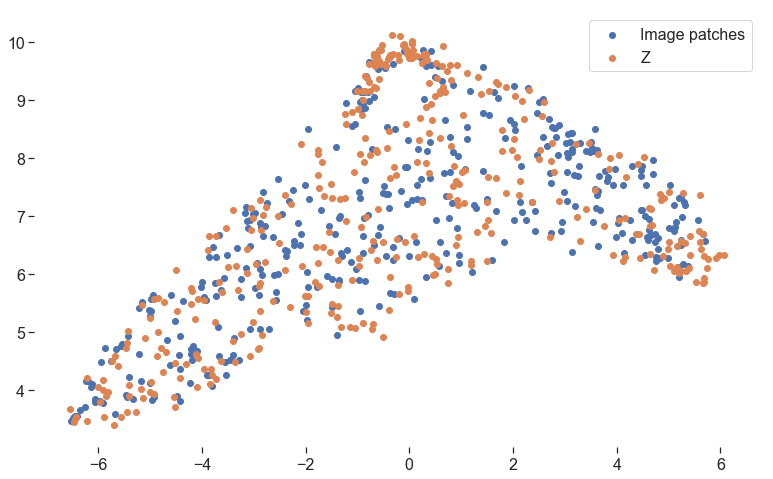

In [93]:
umap_object = umap.UMAP(n_components=2)
umap_object.fit(Z_and_patches)
embedded_Z = umap_object.transform(Z)
embedded_patches = umap_object.transform(patches)
plt.figure(figsize=(13, 8))

plt.scatter(embedded_patches[:, 0], embedded_patches[:, 1], label="Image patches")
plt.scatter(embedded_Z[:, 0], embedded_Z[:, 1], label="Z")
plt.legend();

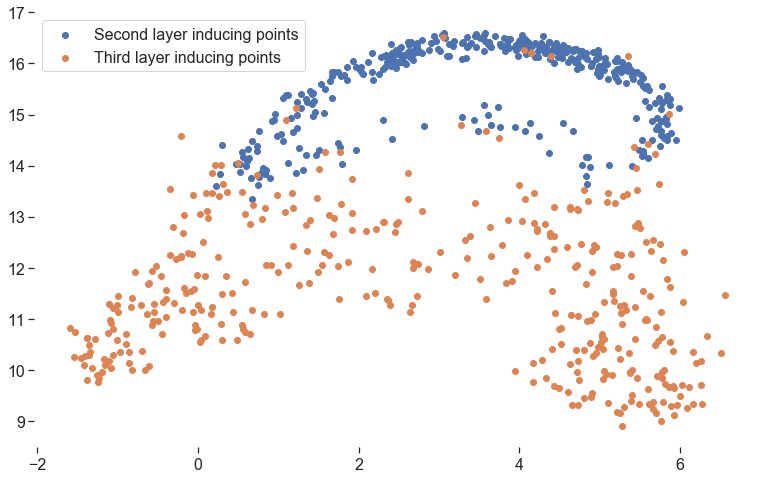

In [17]:
Z1 = model.layers[1].feature.Z.value
Z2 = model.layers[2].feature.Z.value
Z12 = np.concatenate([Z1, Z2], axis=0)

embedder = umap.UMAP(n_components=2)
embedder = embedder.fit(Z12)
Z1 = embedder.transform(Z1)
Z2 = embedder.transform(Z2)

plt.scatter(Z1[:, 0], Z1[:, 1], label="Second layer inducing points")
plt.scatter(Z2[:, 0], Z2[:, 1], label="Third layer inducing points")
plt.legend();

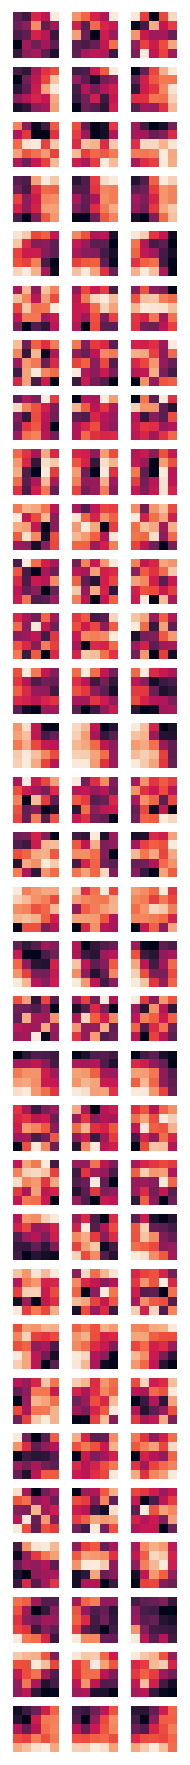

In [76]:
Z1 = model.layers[0].feature.Z.value
Z2 = model.layers[1].feature.Z.value
Z3 = model.layers[2].feature.Z.value

z_count = 32
fm_count = 3

figure = plt.figure(figsize=(fm_count*1, z_count*1))
for i in range(z_count):
    for fm in range(fm_count):
        the_slice = np.arange(0, 75, 3) + fm
        z = Z1[i, the_slice]
        axis = plt.subplot2grid((z_count, fm_count), loc=(i, fm))
        axis.imshow(z.reshape(5, 5))
        axis.xaxis.set_visible(False)
        axis.yaxis.set_visible(False)

In [18]:
by_classes = np.stack([Xtrain[Ytrain==i][0:64] for i in range(10)])

In [19]:
layer1 = np.zeros((10, 64, 10, 10, 10))
layer2 = np.zeros((10, 64, 8, 8, 10))
layer3 = np.zeros((10, 64, 10))
sess = model.enquire_session()

for i in range(10):
    Fs, Fmeans, Fvars = model.propagate(by_classes[i, 0:64].reshape(64, -1), S=1)
    f = sess.run(Fs)
    layer1[i, :, :, :, :] = f[0].reshape(64, 10, 10, 10)
    layer2[i, :, :, :, :] = f[1].reshape(64, 8, 8, 10)
    layer3[i, :, :] = f[2].reshape(64, 10)


In [20]:
from sklearn import manifold

In [54]:
labels = (
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
    )
def plot_images(images, size, loc, title):
    axis = plt.subplot2grid(size, loc=loc)
    embedder = umap.UMAP(n_components=2)
    dim = np.prod(images.shape[2:])
    embedder = embedder.fit(images.reshape(images.shape[1] * images.shape[0], dim))

    plt.title(title)
    for class_index in range(10):
        class_embedded = embedder.transform(images[class_index].reshape(64, dim))
        plt.scatter(class_embedded[:, 0], class_embedded[:, 1], label=labels[class_index])


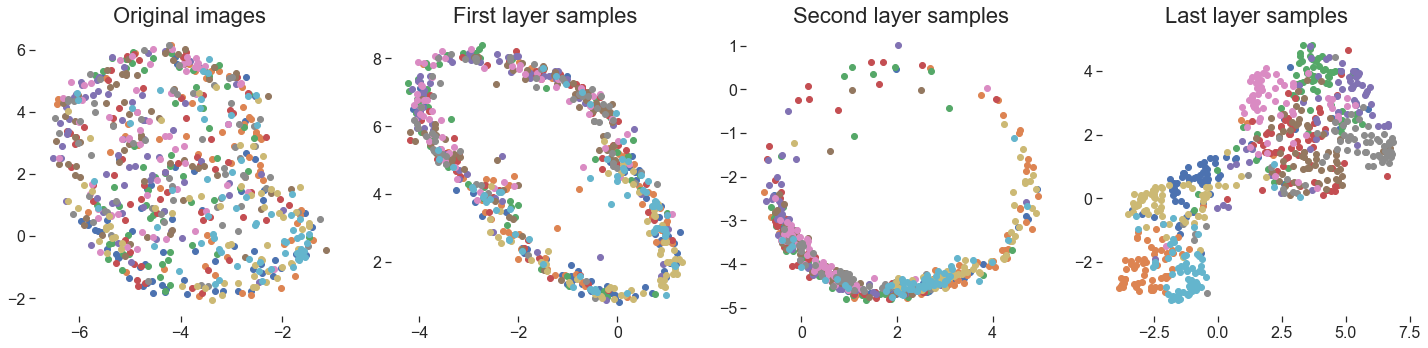

In [59]:
plt.figure(figsize=(20, 5))
plot_images(by_classes, (1, 4), (0, 0), title='Original images')
plot_images(layer1, (1, 4), (0, 1), title='First layer samples')
plot_images(layer2, (1, 4), (0, 2), title='Second layer samples')
plot_images(layer3, (1, 4), (0, 3), title='Last layer samples')
plt.tight_layout();

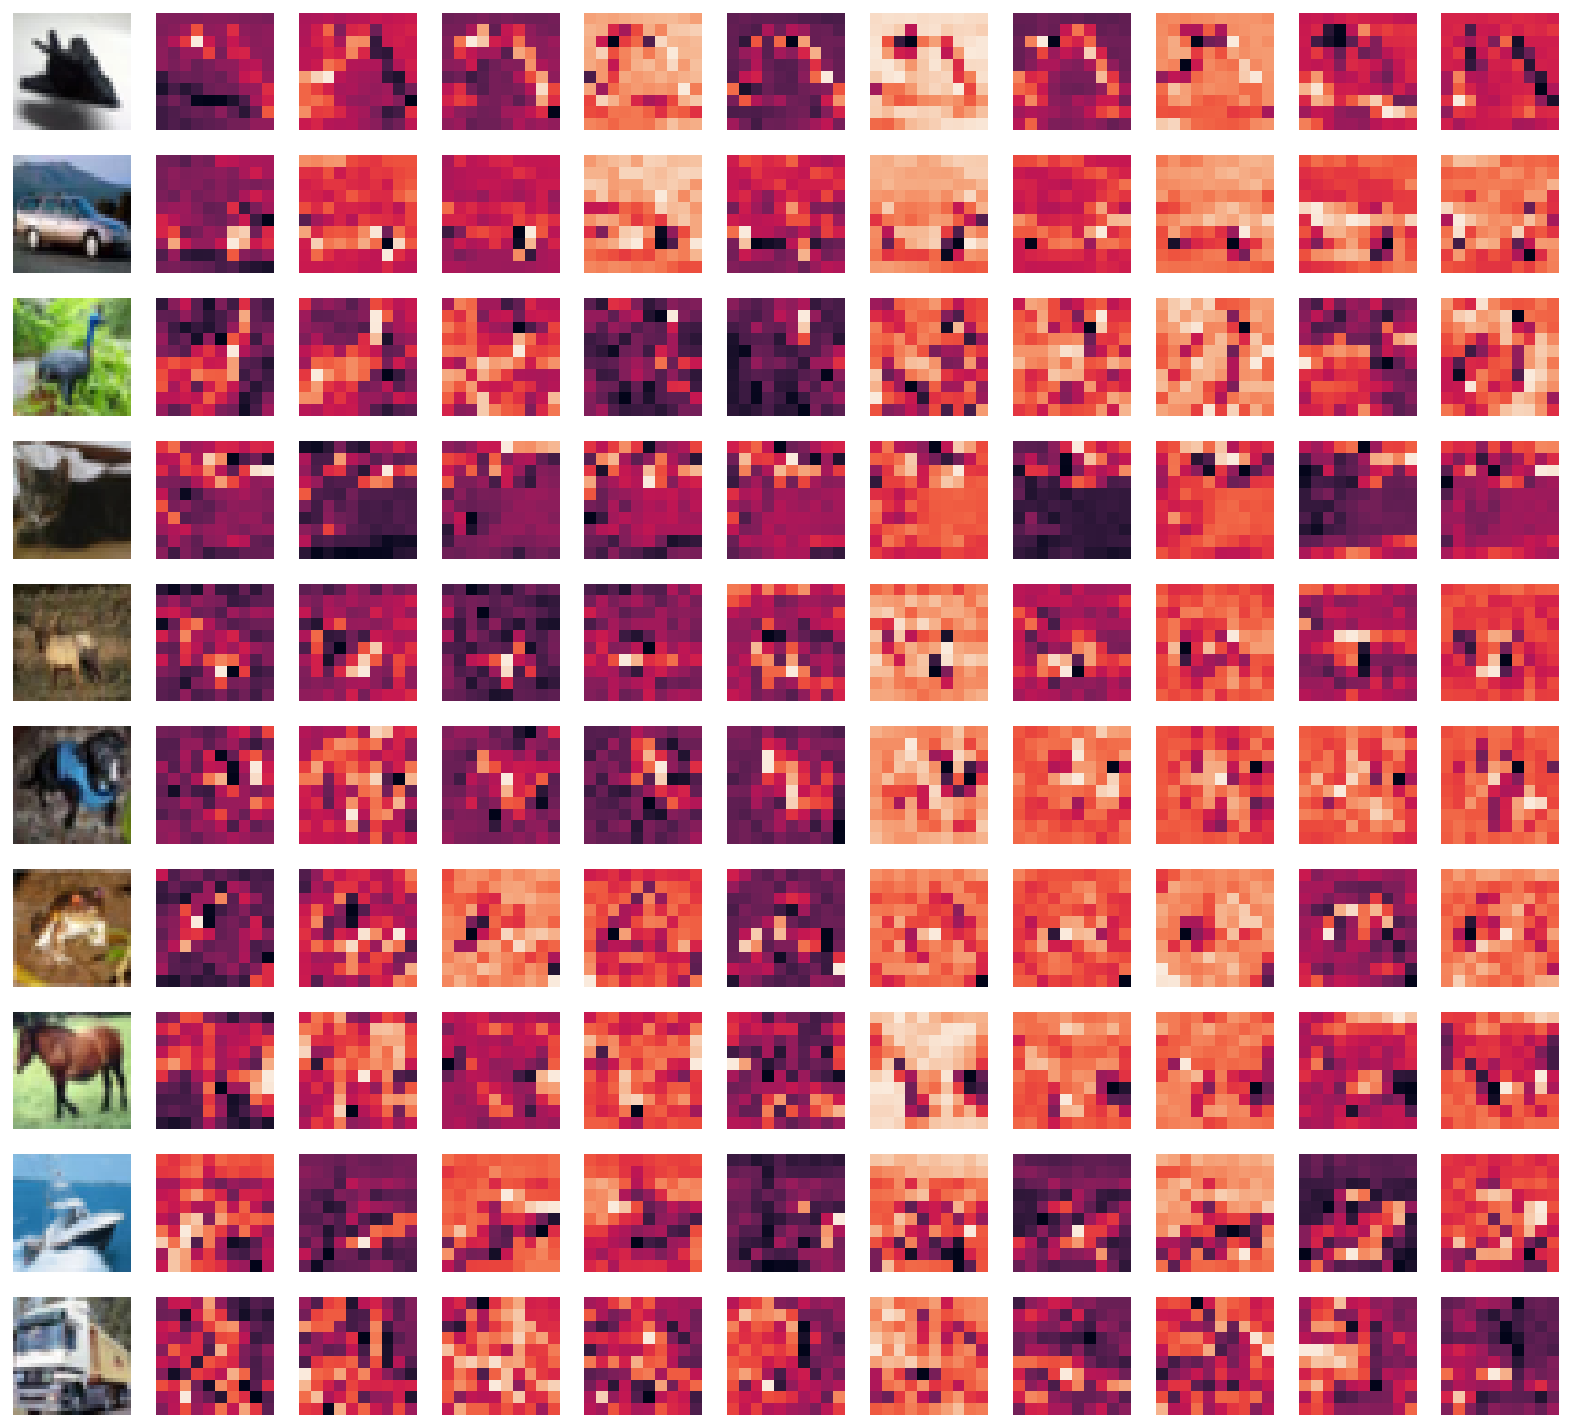

In [49]:
n_feature_maps = 10
figure = plt.figure(figsize=(11 * 2, 20))
for class_index in range(10):
    axis = plt.subplot2grid((10, 1 + n_feature_maps), loc=(class_index, 0))
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    image = by_classes[class_index, 0, :, :, :] * std + mean
    axis.imshow(image)
    for feature_map in range(0, n_feature_maps):
        axis = plt.subplot2grid((10, 1+ n_feature_maps), loc=(class_index, 1 + feature_map))
        axis.xaxis.set_visible(False)
        axis.yaxis.set_visible(False)
        image = layer1[class_index, 0, :, :, feature_map]
        axis.imshow(image)
        
plt.tight_layout();
# The "x-axis" of the grid represents different feature maps and the "y-axis" are activations over different classes.

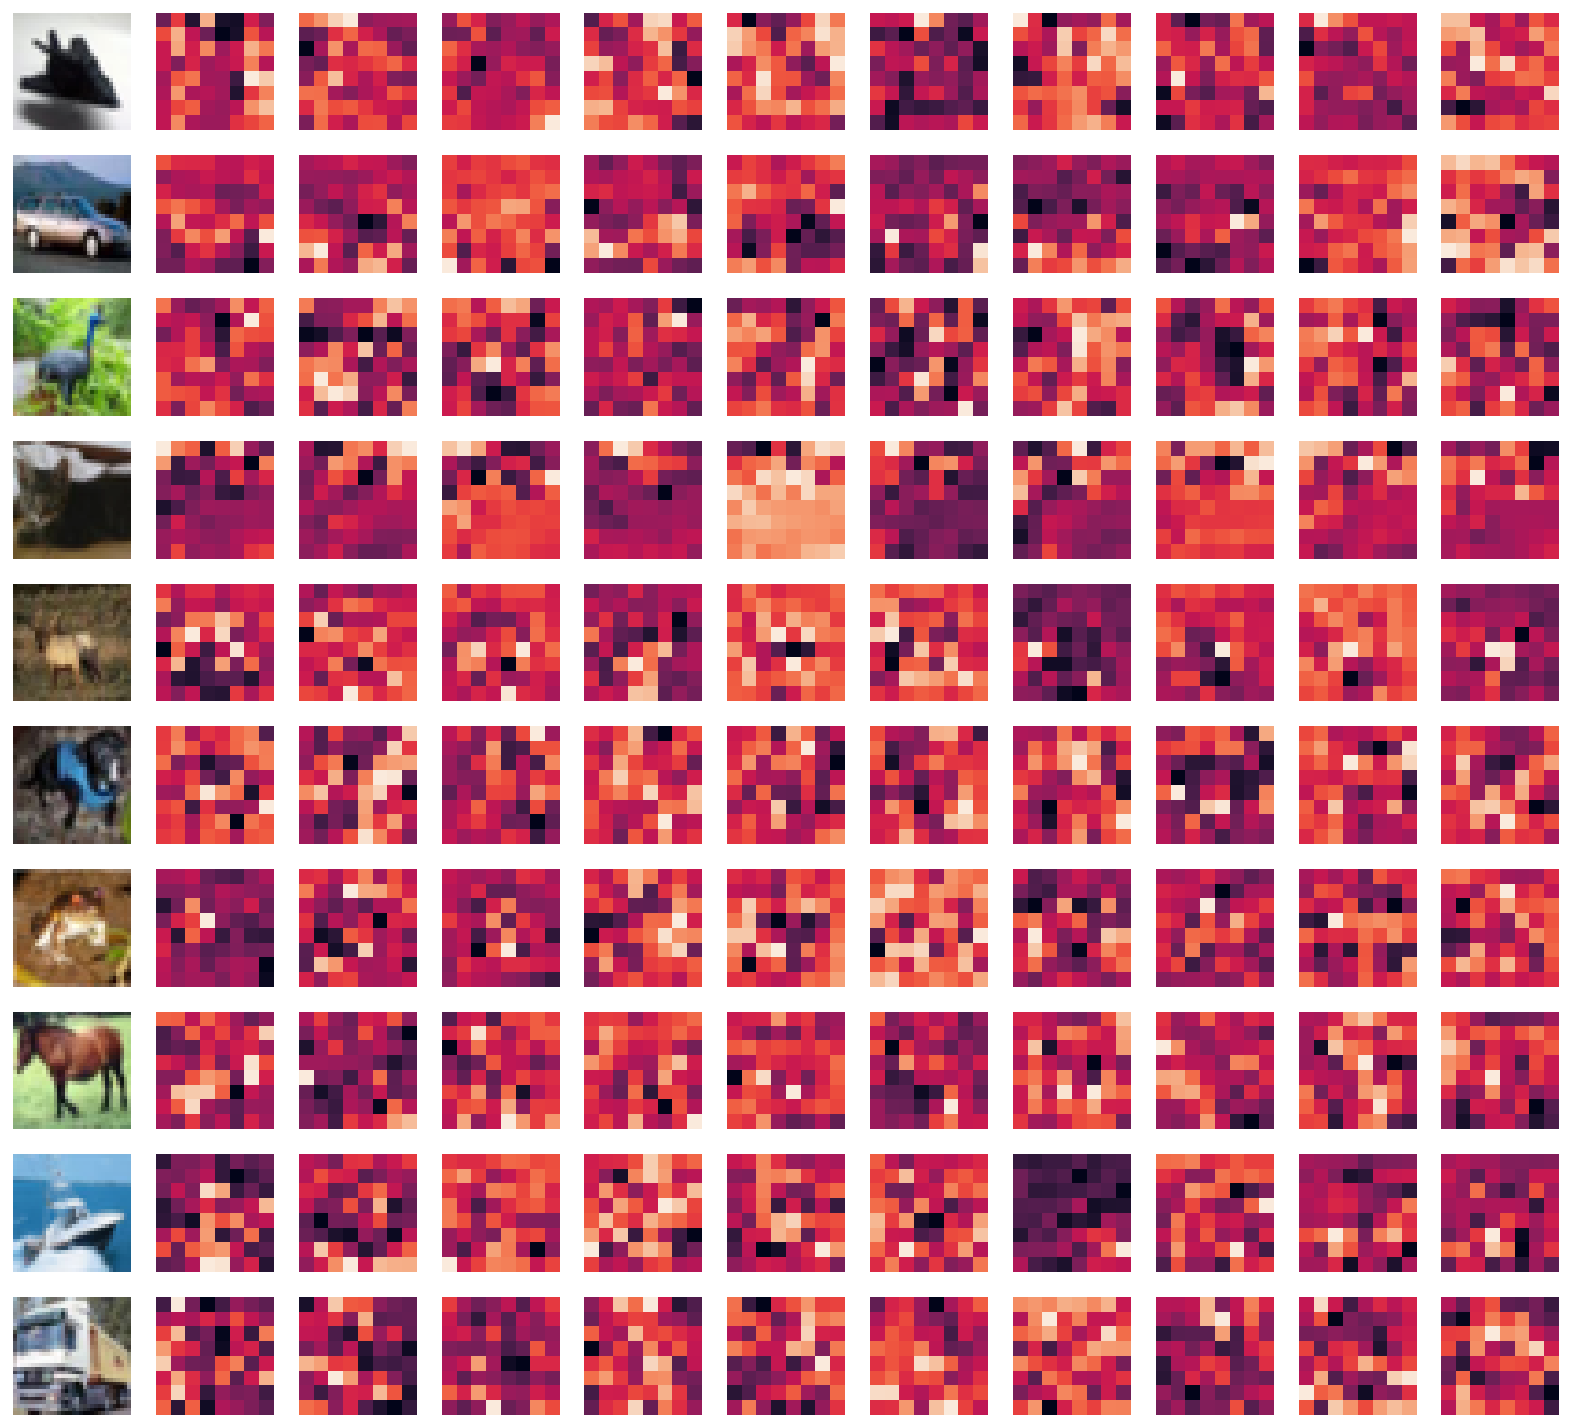

In [52]:
n_feature_maps = 10
figure = plt.figure(figsize=(11 * 2, 20))
for class_index in range(10):
    axis = plt.subplot2grid((10, 1 + n_feature_maps), loc=(class_index, 0))
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    image = by_classes[class_index, 0, :, :, :] * std + mean
    axis.imshow(image)
    for feature_map in range(0, n_feature_maps):
        axis = plt.subplot2grid((10, 1+ n_feature_maps), loc=(class_index, 1 + feature_map))
        axis.xaxis.set_visible(False)
        axis.yaxis.set_visible(False)
        image = layer2[class_index, 0, :, :, feature_map]
        axis.imshow(image)
        
plt.tight_layout();
# The "x-axis" of the grid represents different feature maps and the "y-axis" are activations over different classes.

In [111]:
from sklearn import calibration
probabilities = np.zeros((Xtest.shape[0], 10), dtype=np.float64)

batch_size = 32
for batch_index in range(Xtest.shape[0] // 32 + 1):
    the_slice = slice(batch_index * batch_size, (batch_index+1) * batch_size)
    X = Xtest[the_slice]
    mean, _ = model.predict_y(X.reshape(X.shape[0], -1), 1)
    y = Ytest[the_slice]
    probabilities[the_slice, :] = mean[0]


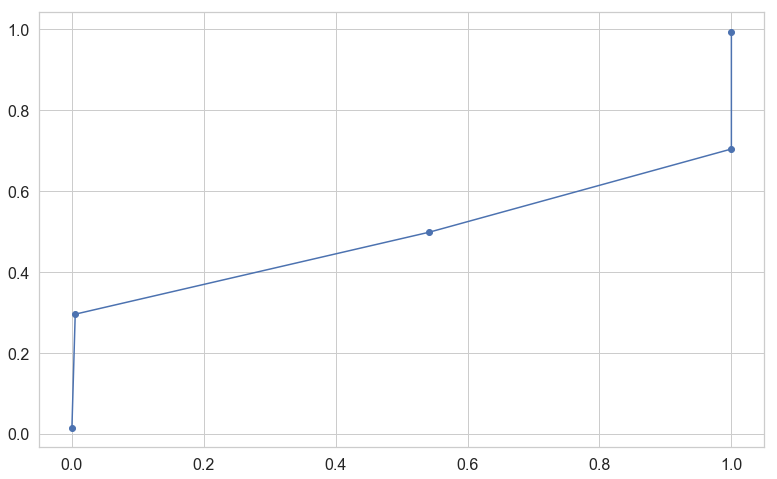

In [154]:
confidence = np.zeros((probabilities.shape[0],))
Y = np.zeros((Ytest.shape[0],), dtype=np.int32)
for i in range(probabilities.shape[0]):
    correct_class_confidence = probabilities[i, Ytest[i]]
    confidence[i] = correct_class_confidence
    Y[i] = Ytest[i] == probabilities[i].argmax()

curve = calibration.calibration_curve(Y, confidence)

plt.plot(curve[0], curve[1], marker='o');

In [145]:
Y = np.zeros((Ytest.shape[0], 10))
for i in range(Ytest.shape[0]):
    Y[i, Ytest[i]] = 1.0

brier_score = np.power(Y - probabilities, 2).mean()
print("Brier score:", brier_score)

Brier score: 0.04872524639426405


In [146]:
(Y - probabilities)[0]

array([-0.00011111, -0.00011111, -0.00011111,  0.00189911, -0.00011111,
       -0.00021139, -0.00011111, -0.00011111, -0.00011112, -0.00011111])

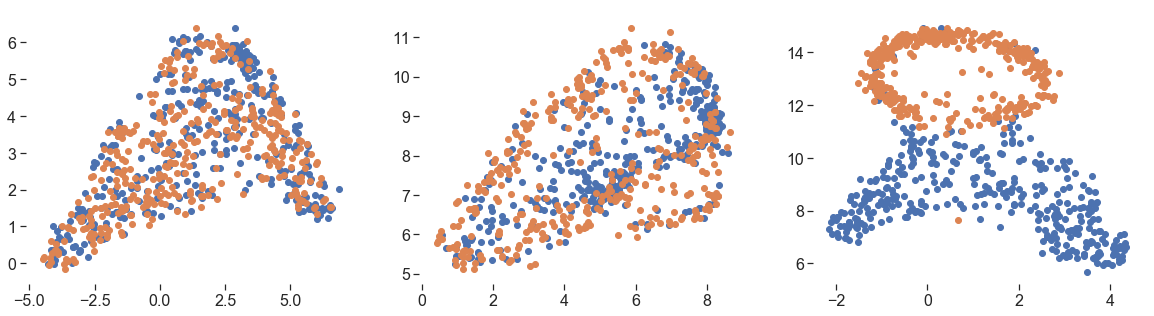

In [134]:
Z1 = model.layers[0].feature.Z.value
patches1 = sample_patches(Xtrain, Z1.shape[0])

Z2 = model.layers[1].feature.Z.value
patches2 = sample_patches(layer1.reshape(-1, *layer1.shape[2:]), n_patches=Z2.shape[0], patch_size=3, feature_maps=10)

Z3 = model.layers[2].feature.Z.value
patches3 = sample_patches(layer2.reshape(-1, *layer2.shape[2:]), n_patches=Z3.shape[0], patch_size=3, feature_maps=10)

def embed(Z, P):
    umapper = umap.UMAP(n_components=2)
    Z_and_P = np.concatenate([Z, P], axis=0)
    umapper.fit(Z_and_P)
    return umapper.transform(Z), umapper.transform(P)

figure = plt.figure(figsize=(4 * 5, 5))
axis = plt.subplot2grid((1, 3), loc=(0, 0))
Z, P = embed(Z1, patches1)
axis.scatter(Z[:, 0], Z[:, 1])
axis.scatter(P[:, 0], P[:, 1])

axis = plt.subplot2grid((1, 3), loc=(0, 1))
Z, P = embed(Z2, patches2)
axis.scatter(Z[:, 0], Z[:, 1])
axis.scatter(P[:, 0], P[:, 1])

axis = plt.subplot2grid((1, 3), loc=(0, 2))
Z, P = embed(Z3, patches3)
axis.scatter(Z[:, 0], Z[:, 1])
axis.scatter(P[:, 0], P[:, 1]);

(384, 90)